In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
%cd '/content/drive/My Drive/MindEye'
os.chdir('/content/drive/My Drive/MindEye')

/content/drive/My Drive/MindEye


In [3]:
!pip install dalle2-pytorch wandb clip-retrieval ImageHash diffusers==0.13.0
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fohwkntx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fohwkntx
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [4]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from functools import partial
import torch.nn.functional as F
from tqdm import tqdm
from dalle2_pytorch import DiffusionPrior
from PIL import Image
from dalle2_pytorch.dalle2_pytorch import l2norm, default, exists
from dalle2_pytorch.dalle2_pytorch import RotaryEmbedding, CausalTransformer, SinusoidalPosEmb, MLP, Rearrange, repeat, rearrange, prob_mask_like, LayerNorm, RelPosBias, Attention, FeedForward
from torchvision import transforms
from utils import load_image, save_image, encode_img, decode_img, to_PIL
import clip
from clip_retrieval.clip_client import ClipClient
import time
import requests
import socket
from urllib.request import Request, urlopen
import imagehash
import io
from diffusers import VersatileDiffusionDualGuidedPipeline, UniPCMultistepScheduler, VersatileDiffusionPipeline
from model import Clipper, BrainNetwork, DiffusionPriorNetwork, BrainDiffusionPrior

In [5]:
dataset_path = '../2023-Machine-Learning-Dataset/'
training_path = dataset_path + 'subj0{}/training_split/'
training_fmri_path = training_path + 'training_fmri/'
training_images_path = training_path + 'training_images/'
testing_path = dataset_path + 'subj0{}/test_split/test_fmri/'
image_infos_path = dataset_path + 'image_infos/subj0{}_infos_train.csv'

In [6]:
class MyDataset(Dataset):
  def __init__(self, fmri_data, images_folder, transform=None):
    self.fmri_data = fmri_data
    self.images_folder = images_folder
    self.image_paths = [f"{images_folder}/{filename}" for filename in os.listdir(images_folder)]
    self.transform = transform

  def __len__(self):
    return len(self.fmri_data)

  def __getitem__(self, idx):
    fmri = self.fmri_data[idx]
    image_path = self.image_paths[idx]
    image = load_image(image_path)

    if(self.transform):
      image = self.transform(image)

    return fmri, image
transform = transforms.Resize([512, 512])

# Load dataset, now only subj01
lh = np.load(training_path.format(1) + 'training_fmri/lh_training_fmri.npy')
rh = np.load(training_path.format(1) + 'training_fmri/rh_training_fmri.npy')
lrh = np.concatenate((lh, rh), axis=1)

my_dataset = MyDataset(lrh, training_images_path.format(1), transform=transform)

In [7]:
commandline_args = os.environ.get('COMMANDLINE_ARGS', "--skip-torch-cuda-test --no-half")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [54]:
def batchwise_cosine_similarity(Z,B):
    B = B.T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity
def decode_latents(latents,vae):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image
def torch_to_Image(x):
    if x.ndim==4:
        x=x[0]
    return transforms.ToPILImage()

In [8]:
def _check_whether_images_are_identical(image1, image2):
    pil_image1 = transforms.ToPILImage()(image1)
    pil_image2 = transforms.ToPILImage()(image2)

    SIMILARITY_THRESHOLD = 90

    image_hash1 = imagehash.phash(pil_image1, hash_size=16)
    image_hash2 = imagehash.phash(pil_image2, hash_size=16)
    return (image_hash1 - image_hash2) < SIMILARITY_THRESHOLD
def query_laion(text=None, emb=None, num=8, indice_name="laion5B-L-14", groundtruth=None, clip_extractor=None, device=None, verbose=False):
    # if isinstance(clip_extractor, OpenClipper):
    #     indice_name = "laion5B-H-14"
    if verbose: print("indice_name", indice_name)

    emb = nn.functional.normalize(emb,dim=-1)
    emb = emb.detach().cpu().numpy()
    laion_transform=transforms.Compose([
        transforms.Resize((512)),
        transforms.CenterCrop((512,512)),
    ])
    laion_transform2=transforms.Compose([
        transforms.Resize((768)),
        transforms.CenterCrop((768,768)),
    ])
    assert len(emb) == 768 or len(emb) == 1024
    if groundtruth is not None:
        if indice_name == "laion5B-L-14":
            groundtruth = transforms.Resize((512,512))(groundtruth)
        elif indice_name == "laion5B-H-14":
            groundtruth = transforms.Resize((768,768))(groundtruth)
        if groundtruth.ndim==4:
            groundtruth=groundtruth[0]
        groundtruth=groundtruth[:3].cpu()

    result = None; res_length = 0
    try:
        client = ClipClient(
            url="https://knn.laion.ai/knn-service",
            indice_name=indice_name,
            num_images=300,
            # aesthetic_score=0,
            # aesthetic_weight=np.random.randint(11),
            use_violence_detector=False,
            use_safety_model=False
        )
        result = client.query(text=text, embedding_input=emb.tolist() if emb is not None else None)
        res_length = len(result)
        if verbose: print(result)
    except:
        try:
            time.sleep(2)
            client = ClipClient(
                url="https://knn.laion.ai/knn-service",
                indice_name=indice_name,
                num_images=300,
                aesthetic_score=5,
                aesthetic_weight=1,
                use_violence_detector=False,
                use_safety_model=False
            )
            result = client.query(text=text, embedding_input=emb.tolist() if emb is not None else None)
            res_length = len(result)
            if verbose: print(result)
        except:
            print("Query failed! Outputting blank retrieved images to prevent crashing.")
            retrieved_images = np.ones((16, 3, 512, 512))
            return retrieved_images

    retrieved_images = None
    tries = 0
    for res in result:
        if tries>=num:
            break
        try:
            if verbose: print(tries, "requesting...")
            # Define a User-Agent header to mimic a web browser, then load the image
            headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
            req = Request(res["url"], headers=headers) # Create a Request object with the URL and headers
            socket.setdefaulttimeout(5) # Set a global timeout for socket operations (in seconds)
            try:
                if verbose: print('socket')
                image_data = urlopen(req).read()
            except socket.timeout:
                raise Exception("Request timed out after 5 seconds")
            img = Image.open(io.BytesIO(image_data))
            # plt.imshow(img); plt.show()
            retrieved_images =  img
            break
            img = transforms.ToTensor()(img)
            if img.shape[0] == 1: #ensure not grayscale
                img = img.repeat(3,1,1)
            img = img[:3]
            if groundtruth is not None:
                if _check_whether_images_are_identical(img, groundtruth):
                    print("matched exact neighbor!")
                    continue
            if indice_name == "laion5B-L-14":
                best_cropped = laion_transform(img)
            else:
                best_cropped = laion_transform2(img)
            if verbose: print(best_cropped.shape)
            if retrieved_images is None:
                retrieved_images = best_cropped[None]
            else:
                retrieved_images = np.vstack((retrieved_images, best_cropped[None]))
            tries += 1
            if verbose: print('retrieved_images',retrieved_images.shape)
        except:
            print('failed')
    if verbose: print('final retrieved_images',retrieved_images.shape)
    return retrieved_images

In [9]:
testImg = Image.open(f"{training_images_path.format(1)}/0.png")
imageInfo = pd.read_csv(image_infos_path.format(1))
token = np.array(imageInfo.columns[2:])

In [ ]:
model, preprocess = clip.load("ViT-L/14", device=device)

In [12]:
image = preprocess(testImg).unsqueeze(0).to(device)
text = clip.tokenize(token).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

100%|███████████████████████████████████████| 890M/890M [00:22<00:00, 42.4MiB/s]


Label probs: [[3.16963822e-04 1.27899139e-05 4.72821557e-05 2.44463299e-05
  2.26248744e-06 6.88278351e-06 3.21330881e-05 1.40357106e-05
  8.82911900e-06 7.57487578e-06 6.21339714e-05 1.88420290e-05
  3.89065008e-06 1.12253556e-05 1.26193889e-04 1.16710267e-04
  7.53094137e-05 3.59455044e-05 4.48730825e-05 9.23533371e-05
  6.24219683e-05 8.39727873e-05 3.64619445e-05 9.53381168e-05
  2.09570517e-05 2.51177698e-04 6.11632058e-05 2.16908706e-03
  1.66299898e-04 2.86976516e-04 7.42171251e-05 1.18287599e-05
  2.47534103e-04 1.01706502e-03 2.02163592e-05 4.20088836e-05
  4.82549585e-05 1.17429714e-04 2.34323059e-04 2.38404522e-04
  7.99169138e-05 7.17164221e-05 1.83110198e-04 1.27306688e-04
  7.17989926e-04 3.41509469e-04 9.44010753e-05 8.82341628e-05
  9.21932660e-05 1.46154925e-04 3.26438094e-05 3.62943756e-05
  2.17135632e-04 1.20805380e-05 3.45351073e-05 2.22462677e-05
  1.74249150e-03 1.12647563e-03 4.58699156e-04 1.51254423e-02
  1.18454732e-02 1.50893786e-04 4.53216163e-03 1.40514481

In [44]:
vd_pipe =  VersatileDiffusionDualGuidedPipeline.from_pretrained("shi-labs/versatile-diffusion", torch_dtype=torch.float16)
vd_pipe = vd_pipe.to(device)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

In [41]:
vd_pipe.scheduler = UniPCMultistepScheduler.from_pretrained("shi-labs/versatile-diffusion", subfolder="scheduler")

In [47]:
vd_pipe.remove_unused_weights()

In [45]:
vd_pipe.image_unet.eval()
vd_pipe.vae.eval()
vd_pipe.image_unet.requires_grad_(False)
vd_pipe.vae.requires_grad_(False)
text_to_image_strength = 0.75
generator = torch.Generator(device=device).manual_seed(0)

In [43]:
image = vd_pipe(prompt="room, chair, books",image = testImg, height=256,width=256, text_to_image_strength=text_to_image_strength, generator=generator).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

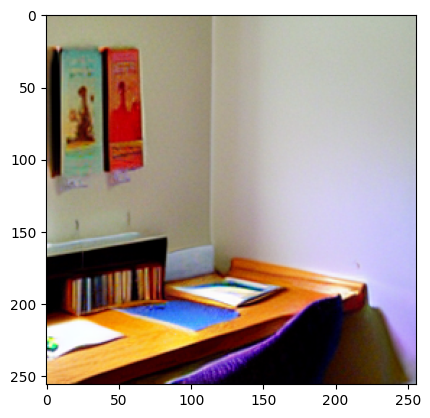

In [44]:
plt.imshow(image)
plt.show()

In [ ]:
image_retrieved = query_laion(emb=image_features.flatten(),groundtruth=None,num=1,clip_extractor=clip_extractor,device=device)

In [ ]:
grid, brain_recons, laion_best_picks, recon_img = utils.reconstruction(
                img, voxel,
                clip_extractor,
                text_token = None,
                img2img_strength = 0.5, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps_prior = 100,
                seed = 42,
                verbose = False,
            )

In [84]:
generator = torch.Generator().manual_seed(42)
trainset, validset = random_split(my_dataset, [0.8, 0.2], generator=generator)
# build dataloader
train_dataloader = DataLoader(trainset, batch_size=16, shuffle=False, num_workers=1)
val_dataloader = DataLoader(validset, batch_size=16, shuffle=False, num_workers=1)

In [13]:
clip_extractor = Clipper("ViT-L/14", device=device)

ViT-L/14 cuda


In [25]:
clip_size = 768
out_dim = clip_size #257*clip_size
depth = 6
dim_head = 64
timesteps = 100
heads = clip_size//64
num_epochs = 120
epoch = 0
losses = []
val_losses = []
lrs = []
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
voxel2clip_kwargs = dict(out_dim=out_dim,clip_size=clip_size,use_projector=True)
voxel2clip = BrainNetwork(**voxel2clip_kwargs).to(device)
prior_network = DiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = 257,
            learned_query_mode="pos_emb"
        ).to(device)
diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
        voxel2clip=voxel2clip,
    ).to(device)
opt_grouped_parameters = [
    {'params': [p for n, p in diffusion_prior.net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in diffusion_prior.net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    {'params': [p for n, p in diffusion_prior.voxel2clip.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in diffusion_prior.voxel2clip.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=1e-3)


diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]

In [97]:
for train_i, data in enumerate(train_dataloader):
  voxels, images = data
  print(voxels.shape,images.shape)
  grid, brain_recons, laion_best_picks, recon_img = reconstruction(image= images[10],voxel = voxels[10].unsqueeze(0),clip_extractor =clip_extractor,diffusion_priors = diffusion_priors,unet = vd_pipe.image_unet,vae = vd_pipe.vae, noise_scheduler=vd_pipe.scheduler,plotting=False)
  voxels = voxels.to(device).float()
  images = images.to(device).float()
  print(voxels.shape,images.shape)
  break

torch.Size([16, 39548]) torch.Size([16, 1, 3, 512, 512])
torch.Size([16, 39548]) torch.Size([16, 1, 3, 512, 512])


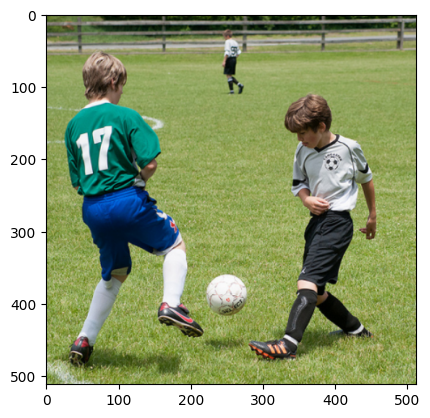

In [98]:
plt.imshow(np.transpose((images[10].cpu().numpy().squeeze(0)*255).astype(int),(1,2,0)))
# plt.imshow(np.transpose(testImg.squeeze(0),(1,2,0)))
plt.show()

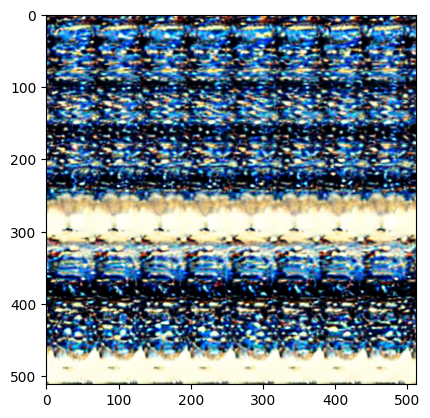

In [99]:
plt.imshow(np.transpose((brain_recons.numpy().squeeze(0).squeeze(0)*255).astype(int),(1,2,0)))
# plt.imshow(np.transpose(testImg.squeeze(0),(1,2,0)))
plt.show()

In [37]:
@torch.no_grad()
def reconstruction(
    image, voxel,
    clip_extractor,
    unet=None,
    vae=None,
    noise_scheduler=None,
    voxel2clip_cls=None,
    diffusion_priors=None,
    text_token = None,
    img_lowlevel = None,
    num_inference_steps = 50,
    recons_per_sample = 1,
    guidance_scale = 7.5,
    img2img_strength = .85,
    timesteps_prior = 100,
    seed = 0,
    retrieve=False,
    plotting=True,
    verbose=False,
    img_variations=False,
    n_samples_save=1,
    num_retrieved=16,
):
    assert n_samples_save==1, "n_samples_save must = 1. Function must be called one image at a time"

    brain_recons = None

    voxel=voxel[:n_samples_save]
    image=image[:n_samples_save]
    do_classifier_free_guidance = False
    if unet is not None:
        do_classifier_free_guidance = guidance_scale > 1.0
        vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
        height = unet.config.sample_size * vae_scale_factor
        width = unet.config.sample_size * vae_scale_factor
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)

    if diffusion_priors is not None:
        if not isinstance(diffusion_priors, list):
            diffusion_priors = [diffusion_priors]
        brain_clip_embeddings_sum = None
        for diffusion_prior in diffusion_priors:
            brain_clip_embeddings0, proj_embeddings = diffusion_prior.voxel2clip(voxel.to(device).float())
            if retrieve:
                continue
            brain_clip_embeddings0 = brain_clip_embeddings0.view(len(voxel),-1,768) #if isinstance(clip_extractor,Clipper) else brain_clip_embeddings0.view(len(voxel),-1,1024)

            if recons_per_sample>0:
                if not img_variations:
                    brain_clip_embeddings0 = brain_clip_embeddings0.repeat(recons_per_sample, 1, 1)
                    try:
                        brain_clip_embeddings = diffusion_prior.p_sample_loop(brain_clip_embeddings0.shape,
                                                text_cond = dict(text_embed = brain_clip_embeddings0),
                                                cond_scale = 1., timesteps = timesteps_prior,
                                                generator=generator)
                    except:
                        brain_clip_embeddings = diffusion_prior.p_sample_loop(brain_clip_embeddings0.shape,
                                                text_cond = dict(text_embed = brain_clip_embeddings0),
                                                cond_scale = 1., timesteps = timesteps_prior)
                else:
                    brain_clip_embeddings0 = brain_clip_embeddings0.view(-1,768)
                    brain_clip_embeddings0 = brain_clip_embeddings0.repeat(recons_per_sample, 1)
                    brain_clip_embeddings = diffusion_prior.p_sample_loop(brain_clip_embeddings0.shape,
                                                text_cond = dict(text_embed = brain_clip_embeddings0),
                                                cond_scale = 1., timesteps = 1000, #1000 timesteps used from nousr pretraining
                                                generator=generator)
                if brain_clip_embeddings_sum is None:
                    brain_clip_embeddings_sum = brain_clip_embeddings
                else:
                    brain_clip_embeddings_sum += brain_clip_embeddings

        # average embeddings for all diffusion priors
        if recons_per_sample>0:
            brain_clip_embeddings = brain_clip_embeddings_sum / len(diffusion_priors)

    if voxel2clip_cls is not None:
        _, cls_embeddings = voxel2clip_cls(voxel.to(device).float())
    else:
        cls_embeddings = proj_embeddings
    if verbose: print("cls_embeddings.",cls_embeddings.shape)

    if retrieve:
        image_retrieved = query_laion(emb=cls_embeddings.flatten(),groundtruth=None,num=num_retrieved,
                                   clip_extractor=clip_extractor,device=device,verbose=verbose)

    if retrieve and recons_per_sample==0:
        brain_recons = torch.Tensor(image_retrieved)
        brain_recons.to(device)
    elif recons_per_sample > 0:
        if not img_variations:
            for samp in range(len(brain_clip_embeddings)):
                brain_clip_embeddings[samp] = brain_clip_embeddings[samp]/(brain_clip_embeddings[samp,0].norm(dim=-1).reshape(-1, 1, 1) + 1e-6)
        else:
            brain_clip_embeddings = brain_clip_embeddings.unsqueeze(1)

        input_embedding = brain_clip_embeddings#.repeat(recons_per_sample, 1, 1)
        if verbose: print("input_embedding",input_embedding.shape)

        if text_token is not None:
            prompt_embeds = text_token.repeat(recons_per_sample, 1, 1)
        else:
            prompt_embeds = torch.zeros(len(input_embedding),77,768)
        if verbose: print("prompt!",prompt_embeds.shape)

        if do_classifier_free_guidance:
            input_embedding = torch.cat([torch.zeros_like(input_embedding), input_embedding]).to(device).to(unet.dtype)
            prompt_embeds = torch.cat([torch.zeros_like(prompt_embeds), prompt_embeds]).to(device).to(unet.dtype)

        # dual_prompt_embeddings
        if not img_variations:
            input_embedding = torch.cat([prompt_embeds.to(device), input_embedding.to(device)], dim=1)

        # 4. Prepare timesteps
        noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps, device=device)

        # 5b. Prepare latent variables
        batch_size = input_embedding.shape[0] // 2 # divide by 2 bc we doubled it for classifier-free guidance
        shape = (batch_size, unet.in_channels, height // vae_scale_factor, width // vae_scale_factor)
        if img_lowlevel is not None: # use img_lowlevel for img2img initialization
            init_timestep = min(int(num_inference_steps * img2img_strength), num_inference_steps)
            t_start = max(num_inference_steps - init_timestep, 0)
            timesteps = noise_scheduler.timesteps[t_start:]
            latent_timestep = timesteps[:1].repeat(batch_size)

            if verbose: print("img_lowlevel", img_lowlevel.shape)
            img_lowlevel_embeddings = clip_extractor.normalize(img_lowlevel)
            if verbose: print("img_lowlevel_embeddings", img_lowlevel_embeddings.shape)
            init_latents = vae.encode(img_lowlevel_embeddings.to(device).to(vae.dtype)).latent_dist.sample(generator)
            init_latents = vae.config.scaling_factor * init_latents
            init_latents = init_latents.repeat(recons_per_sample, 1, 1, 1)

            noise = torch.randn([recons_per_sample, 4, 64, 64], device=device,
                                generator=generator, dtype=input_embedding.dtype)
            init_latents = noise_scheduler.add_noise(init_latents, noise, latent_timestep)
            latents = init_latents
        else:
            timesteps = noise_scheduler.timesteps
            latents = torch.randn([recons_per_sample, 4, 64, 64], device=device,
                                  generator=generator, dtype=input_embedding.dtype)
            latents = latents * noise_scheduler.init_noise_sigma

        # 7. Denoising loop
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

            if verbose: print("latent_model_input", latent_model_input.shape)
            if verbose: print("input_embedding", input_embedding.shape)
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=input_embedding).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # TODO:
                # noise_pred = dynamic_cfg(noise_pred_uncond, noise_pred_text, guidance_scale)

            # compute the previous noisy sample x_t -> x_t-1
            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        recons = decode_latents(latents,vae).detach().cpu()

        brain_recons = recons.unsqueeze(0)

    if verbose: print("brain_recons",brain_recons.shape)

    # pick best reconstruction out of several
    best_picks = np.zeros(n_samples_save).astype(np.int16)

    if retrieve==False:
        v2c_reference_out = nn.functional.normalize(proj_embeddings.view(len(proj_embeddings),-1),dim=-1)
        sims=[]
        for im in range(recons_per_sample):
            currecon = clip_extractor.embed_image(brain_recons[0,[im]].float()).to(proj_embeddings.device).to(proj_embeddings.dtype)
            currecon = nn.functional.normalize(currecon.view(len(currecon),-1),dim=-1)
            cursim = batchwise_cosine_similarity(v2c_reference_out,currecon)
            sims.append(cursim.item())
        if verbose: print(sims)
        best_picks[0] = int(np.nanargmax(sims))
        if verbose: print(best_picks)
    else:
        v2c_reference_out = nn.functional.normalize(proj_embeddings.view(len(proj_embeddings),-1),dim=-1)
        retrieved_clips = clip_extractor.embed_image(torch.Tensor(image_retrieved).to(device)).float()
        sims=[]
        for ii,im in enumerate(retrieved_clips):
            currecon = nn.functional.normalize(im.flatten()[None],dim=-1)
            if verbose: print(v2c_reference_out.shape, currecon.shape)
            cursim = batchwise_cosine_similarity(v2c_reference_out,currecon)
            sims.append(cursim.item())
        if verbose: print(sims)
        best_picks[0] = int(np.nanargmax(sims))
        if verbose: print(best_picks)
        recon_img = image_retrieved[best_picks[0]]

    if recons_per_sample==0 and retrieve:
        recon_is_laion = True
        recons_per_sample = 1 # brain reconstruction will simply be the LAION nearest neighbor
    else:
        recon_is_laion = False

    img2img_samples = 0 if img_lowlevel is None else 1
    laion_samples = 1 if retrieve else 0
    num_xaxis_subplots = 1+img2img_samples+laion_samples+recons_per_sample
    if plotting:
        fig, ax = plt.subplots(n_samples_save, num_xaxis_subplots,
                           figsize=(num_xaxis_subplots*5,6*n_samples_save),facecolor=(1, 1, 1))
    else:
        fig = None
        recon_img = None

    im = 0
    if plotting:
        ax[0].set_title(f"Original Image")
        ax[0].imshow(torch_to_Image(image[im]))
        if img2img_samples == 1:
            ax[1].set_title(f"Img2img ({img2img_strength})")
            ax[1].imshow(torch_to_Image(img_lowlevel[im].clamp(0,1)))
    for ii,i in enumerate(range(num_xaxis_subplots-laion_samples-recons_per_sample,num_xaxis_subplots-laion_samples)):
        recon = brain_recons[im][ii]
        if recon_is_laion:
            recon = brain_recons[best_picks[0]]
        if plotting:
            if ii == best_picks[im]:
                ax[i].set_title(f"Reconstruction",fontweight='bold')
                recon_img = recon
            else:
                ax[i].set_title(f"Recon {ii+1} from brain")
            ax[i].imshow(torch_to_Image(recon))
    if plotting:
        if retrieve and not recon_is_laion:
            ax[-1].set_title(f"LAION5b top neighbor")
            ax[-1].imshow(torch_to_Image(image_retrieved0))
        for i in range(num_xaxis_subplots):
            ax[i].axis('off')

    return fig, brain_recons, best_picks, recon_img

In [12]:
class Clipper(torch.nn.Module):
    def __init__(self, clip_variant, clamp_embs=False, norm_embs=False,
                 hidden_state=False, device=torch.device('cpu')):
        super().__init__()
        assert clip_variant in ("RN50", "ViT-L/14", "ViT-B/32", "RN50x64"), \
            "clip_variant must be one of RN50, ViT-L/14, ViT-B/32, RN50x64"
        print(clip_variant, device)

        if clip_variant=="ViT-L/14" and hidden_state:
            from transformers import CLIPVisionModelWithProjection
            image_encoder = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").eval()
            # image_encoder = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14",cache_dir="/fsx/proj-medarc/fmri/cache")
            #from transformers import CLIPVisionModelWithProjection
            #sd_cache_dir = '/fsx/proj-medarc/fmri/cache/models--shi-labs--versatile-diffusion/snapshots/2926f8e11ea526b562cd592b099fcf9c2985d0b7'
            #image_encoder = CLIPVisionModelWithProjection.from_pretrained(sd_cache_dir, subfolder='image_encoder').eval()
            image_encoder = image_encoder.to(device)
            for param in image_encoder.parameters():
                param.requires_grad = False # dont need to calculate gradients
            self.image_encoder = image_encoder
        elif hidden_state:
            raise Exception("hidden_state embeddings only works with ViT-L/14 right now")

        clip_model, preprocess = clip.load(clip_variant, device=device)
        clip_model.eval() # dont want to train model
        for param in clip_model.parameters():
            param.requires_grad = False # dont need to calculate gradients

        self.clip = clip_model
        self.clip_variant = clip_variant
        if clip_variant == "RN50x64":
            self.clip_size = (448,448)
        else:
            self.clip_size = (224,224)

        preproc = transforms.Compose([
            transforms.Resize(size=self.clip_size[0], interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(size=self.clip_size),
            transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ])
        self.preprocess = preproc
        self.hidden_state = hidden_state
        self.mean = np.array([0.48145466, 0.4578275, 0.40821073])
        self.std = np.array([0.26862954, 0.26130258, 0.27577711])
        self.normalize = transforms.Normalize(self.mean, self.std)
        self.denormalize = transforms.Normalize((-self.mean / self.std).tolist(), (1.0 / self.std).tolist())
        self.clamp_embs = clamp_embs
        self.norm_embs = norm_embs
        self.device= device

        def versatile_normalize_embeddings(encoder_output):
            embeds = encoder_output.last_hidden_state
            embeds = image_encoder.vision_model.post_layernorm(embeds)
            embeds = image_encoder.visual_projection(embeds)
            return embeds
        self.versatile_normalize_embeddings = versatile_normalize_embeddings

    def resize_image(self, image):
        # note: antialias should be False if planning to use Pinkney's Image Variation SD model
        return transforms.Resize(self.clip_size)(image.to(self.device))

    def embed_image(self, image):
        """Expects images in -1 to 1 range"""
        if self.hidden_state:
            # clip_emb = self.preprocess((image/1.5+.25).to(self.device)) # for some reason the /1.5+.25 prevents oversaturation
            clip_emb = self.preprocess((image).to(self.device))
            clip_emb = self.image_encoder(clip_emb)
            clip_emb = self.versatile_normalize_embeddings(clip_emb)
        else:
            clip_emb = self.preprocess(image.to(self.device))
            clip_emb = self.clip.encode_image(clip_emb)
        # input is now in CLIP space, but mind-reader preprint further processes embeddings:
        if self.clamp_embs:
            clip_emb = torch.clamp(clip_emb, -1.5, 1.5)
        if self.norm_embs:
            if self.hidden_state:
                # normalize all tokens by cls token's norm
                clip_emb = clip_emb / torch.norm(clip_emb[:, 0], dim=-1).reshape(-1, 1, 1)
            else:
                clip_emb = nn.functional.normalize(clip_emb, dim=-1)
        return clip_emb

    def embed_text(self, text_samples):
        clip_text = clip.tokenize(text_samples).to(self.device)
        clip_text = self.clip.encode_text(clip_text)
        if self.clamp_embs:
            clip_text = torch.clamp(clip_text, -1.5, 1.5)
        if self.norm_embs:
            clip_text = nn.functional.normalize(clip_text, dim=-1)
        return clip_text

    def embed_curated_annotations(self, annots):
        for i,b in enumerate(annots):
            t = ''
            while t == '':
                rand = torch.randint(5,(1,1))[0][0]
                t = b[0,rand]
            if i==0:
                txt = np.array(t)
            else:
                txt = np.vstack((txt,t))
        txt = txt.flatten()
        return self.embed_text(txt)